## Gait Video Study 
### Traditional ML algorithms on 2 task generalization frameworks, namely a) W-> WT b) VBW-> VBWT, to classify HOA/MS/PD strides and subjects 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model

1. Save the optimal hyperparameters, confusion matrices and ROC curves for each algorithm.
2. Make sure to not use x, y, z, confidence = 0, 0, 0, 0 as points for the model since they are simply missing values and not data points, so make sure to treat them before inputting to model 
3. Make sure to normalize (z-score normalization) the features before we feed them to the model.
4. We use the summary statistics as range, CoV and asymmetry between the right and left limbs as the features to input to the traditional models requiring fixed size 1D input for each training/testing set sample.
5. Since we are implementating "pure" task generalization, we train and test on exactly same subjects i.e. we only retain common subjects across W and WT for a) and only retain common subjects across VBW and VBWT for b).


In [23]:
# 33 subject in total (~10 per group) 
# 4500 strides - 2000 strides - 200 groups for 10 strides per group
# STRIDE - 20*36 - MEAN SUBSTRACTION --- BATCH NORM. 
# 90 features - 36 Cov, 36 Range, 18 assymetry, 18 DEN
# Z-SCORE 
# Default + Dimensionality reduction - 3D space
# Try top 10 features 
# Subject generalization is where the overfitting issue is tested - If we get good results, that means we are not 
# overfitting 

#Check how is AUC 1 even when accurcay is low?

In [64]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import task_gen_traditionalML
reload(task_gen_traditionalML)
from ml_utils.task_gen_traditionalML import keep_subjects_common_across_train_test, normalize, models, evaluate
from ml_utils.task_gen_traditionalML import plot_ROC

In [65]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\MLresults\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,right hip-y-CoV,right hip-z-CoV,right knee-x-CoV,right knee-y-CoV,right knee-z-CoV,right ankle-x-CoV,right ankle-y-CoV,right ankle-z-CoV,left hip-x-CoV,left hip-y-CoV,left hip-z-CoV,left knee-x-CoV,left knee-y-CoV,left knee-z-CoV,left ankle-x-CoV,left ankle-y-CoV,left ankle-z-CoV,left toe 1-x-CoV,left toe 1-y-CoV,left toe 1-z-CoV,left toe 2-x-CoV,left toe 2-y-CoV,left toe 2-z-CoV,left heel-x-CoV,left heel-y-CoV,left heel-z-CoV,right toe 1-x-CoV,right toe 1-y-CoV,right toe 1-z-CoV,right toe 2-x-CoV,right toe 2-y-CoV,right toe 2-z-CoV,right heel-x-CoV,right heel-y-CoV,right heel-z-CoV,right hip-x-range,right hip-y-range,right hip-z-range,right knee-x-range,right knee-y-range,right knee-z-range,right ankle-x-range,right ankle-y-range,right ankle-z-range,left hip-x-range,left hip-y-range,left hip-z-range,left knee-x-range,left knee-y-range,left knee-z-range,left ankle-x-range,left ankle-y-range,left ankle-z-range,left toe 1-x-range,left toe 1-y-range,left toe 1-z-range,left toe 2-x-range,left toe 2-y-range,left toe 2-z-range,left heel-x-range,left heel-y-range,left heel-z-range,right toe 1-x-range,right toe 1-y-range,right toe 1-z-range,right toe 2-x-range,right toe 2-y-range,right toe 2-z-range,right heel-x-range,right heel-y-range,right heel-z-range,hip-x-asymmetry,hip-y-asymmetry,hip-z-asymmetry,knee-x-asymmetry,knee-y-asymmetry,knee-z-asymmetry,ankle-x-asymmetry,ankle-y-asymmetry,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,0.034890,0.004297,0.095552,0.023449,0.034296,0.165017,0.140369,0.442588,0.233172,0.038750,0.004312,0.145337,0.026852,0.013372,0.154423,0.127961,0.203480,0.190814,0.107154,0.827100,0.231699,0.119630,0.787178,0.162847,0.100844,0.468157,0.157325,0.064312,1.198913,0.141141,0.065652,1.200924,0.143717,0.122637,0.585683,7.212309,20.620270,1.991843,9.964181,13.444621,9.038304,21.594528,76.063625,31.074113,13.329466,21.961515,1.991843,9.858765,14.225126,3.894683,14.372807,55.463843,16.647940,16.425025,65.548873,21.766010,22.508497,60.997153,22.014344,16.300582,58.040586,23.324031,15.922455,34.098386,13.121999,17.271819,29.814971,13.798620,12.893203,68.703027,22.493666,6.117157,1.341245,0.0,0.105416,0.780506,5.143621,7.221721,20.599782,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,0.025036,0.003412,0.056296,0.023447,0.033758,0.125686,0.098426,0.302237,0.155463,0.025771,0.003424,0.083200,0.020327,0.030703,0.091782,0.081066,0.255452,0.091156,0.051776,0.832680,0.117199,0.056504,0.898666,0.091052,0.075414,0.299964,0.088011,0.123339,0.673944,0.115438,0.125203,0.673359,0.128054,0.111051,0.422984,3.414412,13.464709,1.247746,5.697790,12.715020,9.394594,12.082187,37.163109,15.383479,4.778190,11.777324,1.247746,4.225919,8.137347,9.608517,8.598281,30.531277,14.022632,8.250031,24.865688,15.579627,9.085920,36.896358,23.869958,8.331596,33.077938,14.108215,9.275678,53.132088,18.250708,15.764214,51.955183,18.966380,13.486903,44.441744,18.441991,1.363778,1.687386,0.0,1.471870,4.577674,0.213923,3.483906,6.631832,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,0.021444,0.000000,0.093182,0.027562,0.039129,0.219685,0.079954,0.389772,0.123618,0.034152,0.000000,0.137763,0.040302,0.029402,0.184402,0.078119,0.365340,0.180999,0.070197,1.049169,0.232832,0.090458,1.039036,0.184111,0.099589,0.444482,0.187098,0.068151,1.359888,0.215648,0.071937,1.176031,0.240568,0.087482,0.516042,3.851961,10.182146,0.000000,9.139212,13.880261,12.388595,19.428682,47.954633,23.423173,2.608223,13.066705,0.000000,7.518423,16.418774,8.928109,14.149397,45.568276,22.082152,15.827351,

### main() 

### Task generalization framework 1: train on walking (W) and test on walking while talking (WT) to classify HOA/MS/PD strides and subjects 

In [53]:
#Trial W for training 
trialW = data[data['scenario']=='W']
#Trial WT for testing 
trialWT = data[data['scenario']=='WT']

#Trial W and WT after making sure both training and testing sets have common subjects 
trialW_reduced, trialWT_reduced = keep_subjects_common_across_train_test(trialW, trialWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialW_reduced = shuffle(trialW_reduced, random_state = 0)
trainX = trialW_reduced.drop(cols_to_drop, axis = 1)
trainY = trialW_reduced[['PID', 'label']]
print ('Training shape', trainX.shape, trainY.shape)

#Shuffling the testing stride data 
trialWT_reduced = shuffle(trialWT_reduced, random_state = 0)
testX = trialWT_reduced.drop(cols_to_drop, axis = 1)
testY = trialWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX.shape, testY.shape)

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(trainX, 'z')
trainX_norm = (trainX-norm_mean)/norm_sd
testX_norm = (testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialWT_reduced['cohort'].value_counts()/trialWT_reduced['cohort'].value_counts()['HOA'])

framework = 'WtoWT' #Defining the task generalization framework of interest

Original number of subjects in training and test sets: 32 26
Subjects in test set, which are not in training set
[403]
Subjects in training set, which are not in test set
[312, 102, 112, 113, 115, 123, 124]
Number of subjects in training and test sets after reduction: 25 25
Training shape (1128, 91) (1128, 2)
Testing shape (1142, 91) (1142, 2)
Strides in training set:  1128
HOA, MS and PD strides in training set:
 PD     453
MS     341
HOA    334
Name: cohort, dtype: int64

Strides in test set:  1142
HOA, MS and PD strides in test set:
 PD     459
HOA    351
MS     332
Name: cohort, dtype: int64
Imbalance ratio (controls:MS:PD)= 1:X:Y
 PD     1.307692
HOA    1.000000
MS     0.945869
Name: cohort, dtype: float64


In [54]:
trialWT.groupby(['video']).count()

,key,cohort,trial,scenario,PID,stride_number,frame_count,label,right hip-x-CoV,right hip-y-CoV,right hip-z-CoV,right knee-x-CoV,right knee-y-CoV,right knee-z-CoV,right ankle-x-CoV,right ankle-y-CoV,right ankle-z-CoV,left hip-x-CoV,left hip-y-CoV,left hip-z-CoV,left knee-x-CoV,left knee-y-CoV,left knee-z-CoV,left ankle-x-CoV,left ankle-y-CoV,left ankle-z-CoV,left toe 1-x-CoV,left toe 1-y-CoV,left toe 1-z-CoV,left toe 2-x-CoV,left toe 2-y-CoV,left toe 2-z-CoV,left heel-x-CoV,left heel-y-CoV,left heel-z-CoV,right toe 1-x-CoV,right toe 1-y-CoV,right toe 1-z-CoV,right toe 2-x-CoV,right toe 2-y-CoV,right toe 2-z-CoV,right heel-x-CoV,right heel-y-CoV,right heel-z-CoV,right hip-x-range,right hip-y-range,right hip-z-range,right knee-x-range,right knee-y-range,right knee-z-range,right ankle-x-range,right ankle-y-range,right ankle-z-range,left hip-x-range,left hip-y-range,left hip-z-range,left knee-x-range,left knee-y-range,left knee-z-range,left ankle-x-range,left ankle-y-range,left ankle-z-range,left toe 1-x-range,left toe 1-y-range,left toe 1-z-range,left toe 2-x-range,left toe 2-y-range,left toe 2-z-range,left heel-x-range,left heel-y-range,left heel-z-range,right toe 1-x-range,right toe 1-y-range,right toe 1-z-range,right toe 2-x-range,right toe 2-y-range,right toe 2-z-range,right heel-x-range,right heel-y-range,right heel-z-range,hip-x-asymmetry,hip-y-asymmetry,hip-z-asymmetry,knee-x-asymmetry,knee-y-asymmetry,knee-z-asymmetry,ankle-x-asymmetry,ankle-y-asymmetry,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
video,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GVS_212_W_T1,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46
GVS_213_W_T2,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
GVS_214_W_T2,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
GVS_215_W_T2,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44
GVS_216_W_T1,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
GVS_217_W_T2,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
GVS_218_W_T1,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
GVS_219_W_T1,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,

In [55]:
trialW['PID'].unique()

array([212, 213, 214, 215, 216, 217, 218, 219, 310, 311, 312, 313, 314,
       318, 320, 321, 322, 323, 404, 405, 406, 407, 408, 409, 410, 411,
       102, 112, 113, 115, 123, 124], dtype=int64)

In [56]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  \
             'linear_svm', 'mlp']
metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 

#For storing predicted probabilities for person (for all classes HOA/MS/PD) to show ROC curves 
predicted_probs_person = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

logistic_regression
Stride-based model performance:  0.7889667250437828 0.7844329710473956 0.780298166017514 0.7794780351394589 0.919476944454852
LogisticRegression(random_state=0)
Person-based model performance:  0.92 0.9333333333333332 0.9259259259259259 0.9212962962962964 1.0


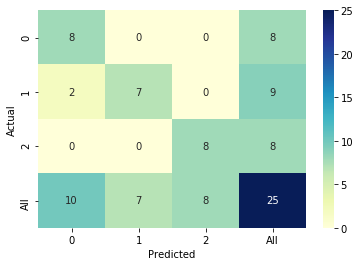

********************************
random_forest
Stride-based model performance:  0.6094570928196147 0.6122942499038864 0.6020795095919121 0.600248479695412 0.8276697028261019
RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=0.05,
                       n_estimators=40, random_state=0)
Person-based model performance:  0.6 0.6296296296296297 0.6018518518518519 0.6084656084656085 0.7809606481481483


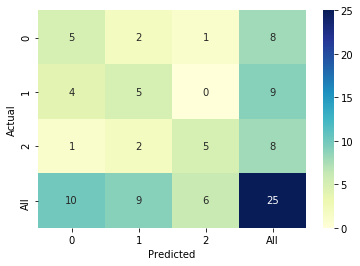

********************************
adaboost
Stride-based model performance:  0.5761821366024519 0.5576669280868742 0.5596813262771212 0.5564451889949177 0.7785847877292086
AdaBoostClassifier(learning_rate=0.01, n_estimators=150, random_state=0)
Person-based model performance:  0.48 0.47095959595959597 0.49074074074074076 0.4726608187134503 0.7307581018518517


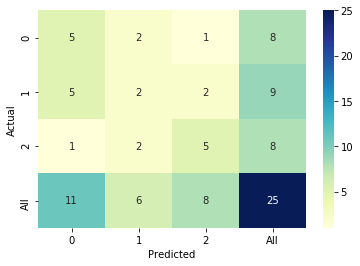

********************************
kernel_svm
Stride-based model performance:  0.6760070052539404 0.6644415187677702 0.6645309240986066 0.6643390252491451 0.8621575415242457
SVC(gamma=0.001, probability=True, random_state=0)
Person-based model performance:  0.68 0.6805555555555555 0.6805555555555555 0.6805555555555555 0.8741319444444443


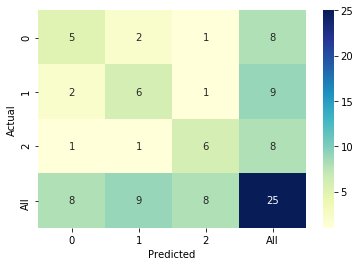

********************************
gbm
Stride-based model performance:  0.841506129597198 0.8406406700980099 0.833624425639545 0.8323698908382614 0.9481602773058354
GradientBoostingClassifier(learning_rate=0.15, max_depth=7, max_features=4,
                           min_samples_split=4, random_state=0)
Person-based model performance:  0.92 0.9259259259259259 0.9259259259259259 0.9191176470588237 0.9976851851851851


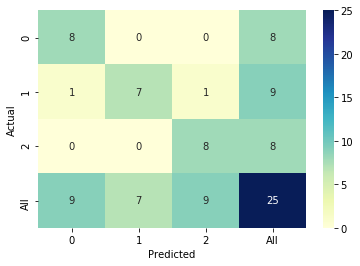

********************************
xgboost
Stride-based model performance:  0.8327495621716288 0.8262784255354337 0.8210658958946225 0.8205672230681907 0.945566389972555
XGBClassifier(colsample_bytree=0.8, gamma=0.5, max_depth=5, min_child_weight=5,
              objective='multi:softprob', subsample=0.6)
Person-based model performance:  0.96 0.9629629629629629 0.9629629629629629 0.9607843137254902 0.9976851851851851


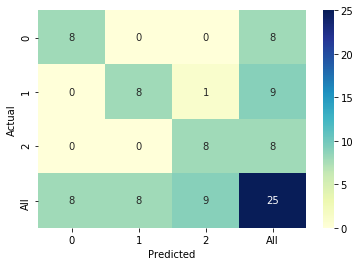

********************************
knn
Stride-based model performance:  0.7854640980735552 0.7904150338733024 0.77497773901034 0.7705020828129192 0.9423352077284801
KNeighborsClassifier(n_neighbors=10, p=1)
Person-based model performance:  0.84 0.8888888888888888 0.8472222222222222 0.8444444444444444 0.9976851851851851


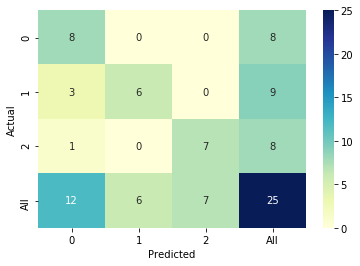

********************************
decision_tree
Stride-based model performance:  0.6943957968476357 0.6848542163205189 0.6851382402410042 0.6845654752393048 0.8181122593521645
DecisionTreeClassifier(min_samples_split=35, random_state=0)
Person-based model performance:  0.92 0.9259259259259259 0.9259259259259259 0.9191176470588237 0.9907407407407408


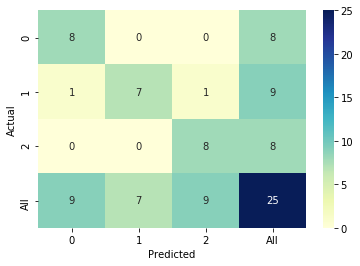

********************************
linear_svm
Stride-based model performance:  0.7775831873905429 0.7722692067367074 0.7695227028442241 0.7681018740935913 0.9096447736585631
LinearSVC(loss='hinge', random_state=0)
Person-based model performance:  0.96 0.9629629629629629 0.9629629629629629 0.9607843137254902 0.9930555555555557


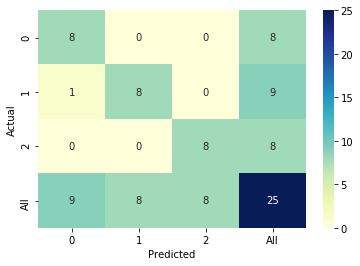

********************************
mlp
Stride-based model performance:  0.7994746059544658 0.7919649208490996 0.7886806148677162 0.7877607791170326 0.9183261420882931
MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50, 60, 50, 50, 60, 60),
              learning_rate='adaptive', max_iter=500, random_state=0,
              shuffle=False)
Person-based model performance:  0.88 0.8962962962962964 0.8888888888888888 0.8766884531590415 0.9953703703703703


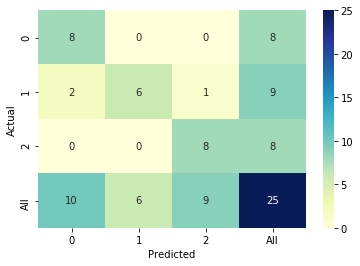

********************************


In [57]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(trainX_norm, trainY, testX_norm, testY, ml_model, framework, results_path, save_results)  
    metrics[ml_model] = stride_person_metrics
    predicted_probs_person[ml_model+'_HOA'] = predict_probs_person[0]
    predicted_probs_person[ml_model+'_MS'] = predict_probs_person[1]
    predicted_probs_person[ml_model+'_PD'] = predict_probs_person[2]
    print ('********************************')

metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
if save_results:
    metrics.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
    predicted_probs_person.to_csv(results_path +framework+ '\\task_generalize_'+framework+'_prediction_probs.csv')

In [58]:
metrics

,logistic_regression,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,mlp
stride_accuracy,0.788967,0.609457,0.576182,0.676007,0.841506,0.832750,0.785464,0.694396,0.777583,0.799475
stride_precision,0.784433,0.612294,0.557667,0.664442,0.840641,0.826278,0.790415,0.684854,0.772269,0.791965
stride_recall,0.780298,0.602080,0.559681,0.664531,0.833624,0.821066,0.774978,0.685138,0.769523,0.788681
stride_F1,0.779478,0.600248,0.556445,0.664339,0.832370,0.820567,0.770502,0.684565,0.768102,0.787761
stride_AUC,0.919477,0.827670,0.778585,0.862158,0.948160,0.945566,0.942335,0.818112,0.909645,0.918326
person_accuracy,0.920000,0.600000,0.480000,0.680000,0.920000,0.960000,0.840000,0.920000,0.960000,0.880000
person_precision,0.933333,0.629630,0.470960,0.680556,0.925926,0.962963,0.888889,0.925926,0.962963,0.896296
person_recall,0.925926,0.601852,0.490741,0.680556,0.925926,0.962963,0.847222,0.925926,0.962963,0.888889
person_F1,0.921296,0.608466,0.472661,0.680556,0.919118,0.960784,0.844444,0.919118,0.960784,0.876688
person_AUC,1.000000,0.780961,0.730758,0.874132,0.997685,0.997685,0.997685,0.990741,0.993056,0.995370


<Figure size 432x288 with 0 Axes>

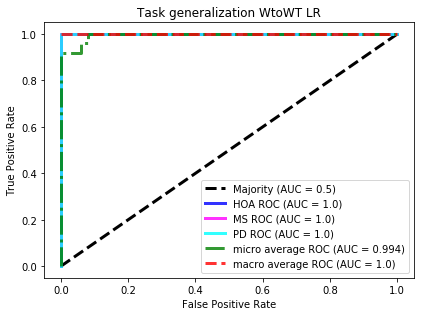

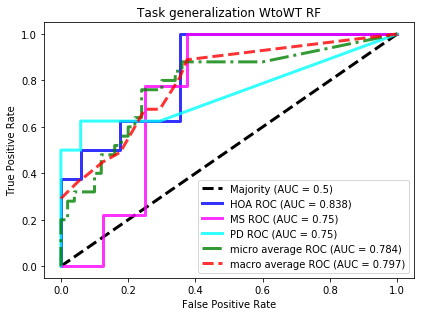

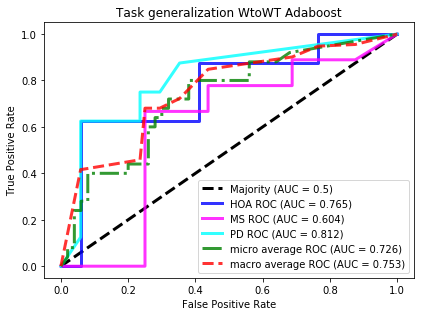

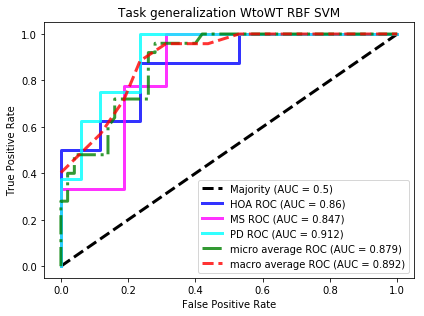

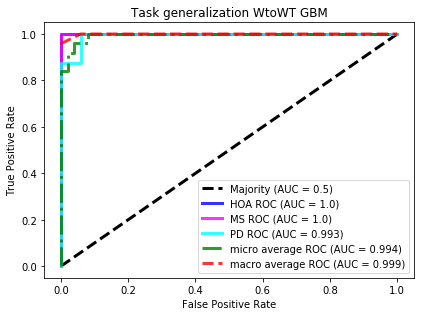

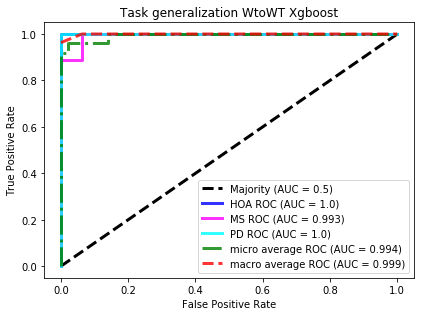

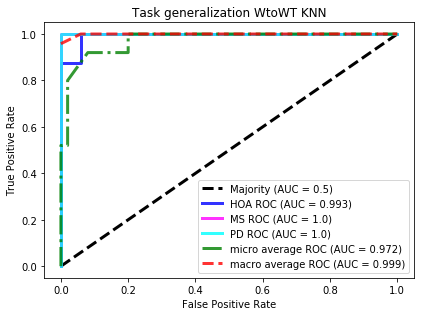

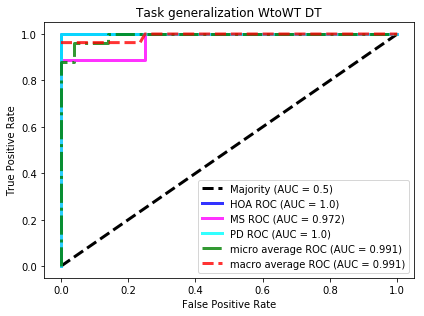

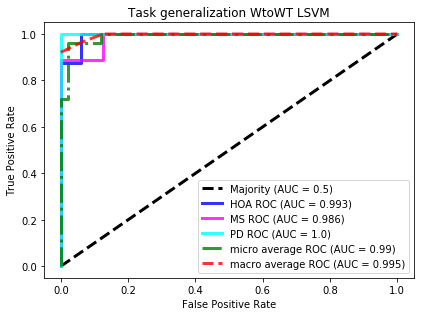

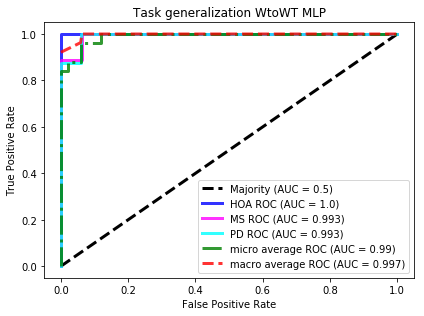

In [59]:
plot_ROC(ml_models, testY, predicted_probs_person, framework, results_path, save_results)

###  Task generalization framework 2: train on virtual beam walking (VBW) and test on virtual beam walking while talking (VBWT) with traditional ML algorithms to classify strides and subjects in HOA/MS/PD groups

In [66]:
#Trial VBW for training 
trialVBW = data[data['scenario']=='SLW']
#Trial VBWT for testing 
trialVBWT = data[data['scenario']=='SLWT']

#Trial VBW and VBWT after making sure both training and testing sets have common subjects 
trialVBW_reduced, trialVBWT_reduced = keep_subjects_common_across_train_test(trialVBW, trialVBWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialVBW_reduced = shuffle(trialVBW_reduced, random_state = 0)
trainX_VBW = trialVBW_reduced.drop(cols_to_drop, axis = 1)
trainY_VBW = trialVBW_reduced[['PID', 'label']]
print ('Training shape', trainX_VBW.shape, trainY_VBW.shape)

#Shuffling the testing stride data 
trialVBWT_reduced = shuffle(trialVBWT_reduced, random_state = 0)
testX_VBWT = trialVBWT_reduced.drop(cols_to_drop, axis = 1)
testY_VBWT = trialVBWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX_VBWT.shape, testY_VBWT.shape)

#Normalize according to z-score standardization
norm_mean_VB, norm_sd_VB = normalize(trainX_VBW, 'z')
trainX_norm_VBW = (trainX_VBW-norm_mean_VB)/norm_sd_VB
testX_norm_VBWT = (testX_VBWT-norm_mean_VB)/norm_sd_VB

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialVBW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialVBW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialVBWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialVBWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialVBWT_reduced['cohort'].value_counts()/trialVBWT_reduced['cohort'].value_counts()['HOA'])

framework = 'VBWtoVBWT' #Defining the task generalization framework of interest

Original number of subjects in training and test sets: 22 21
Subjects in test set, which are not in training set
[]
Subjects in training set, which are not in test set
[323]
Number of subjects in training and test sets after reduction: 21 21
Training shape (789, 91) (789, 2)
Testing shape (837, 91) (837, 2)
Strides in training set:  789
HOA, MS and PD strides in training set:
 HOA    336
MS     243
PD     210
Name: cohort, dtype: int64

Strides in test set:  837
HOA, MS and PD strides in test set:
 HOA    341
MS     254
PD     242
Name: cohort, dtype: int64
Imbalance ratio (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.744868
PD     0.709677
Name: cohort, dtype: float64


In [67]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VB = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for classes HOA/MS/PD) to show ROC curves 
predicted_probs_person_VB = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

random_forest
Stride-based model performance:  0.5615292712066906 0.5676411475974281 0.5586097425638377 0.5568947435388436 0.7469402734948721
RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=0.1,
                       n_estimators=45, random_state=0)
Person-based model performance:  0.6666666666666666 0.7005291005291004 0.6626984126984127 0.6666666666666666 0.8020833333333334


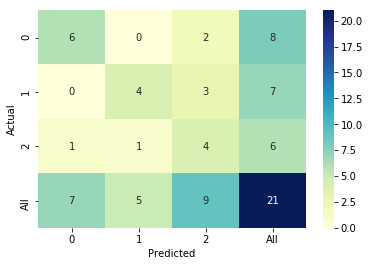

********************************
adaboost
Stride-based model performance:  0.5686977299880526 0.5483238144851418 0.548050878470903 0.5475108583475042 0.7786360843821111
AdaBoostClassifier(learning_rate=0.1, random_state=0)
Person-based model performance:  0.6666666666666666 0.6738095238095237 0.6567460317460317 0.6462056462056461 0.8526785714285715


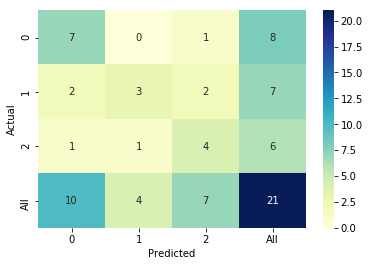

********************************
kernel_svm
Stride-based model performance:  0.4074074074074074 0.13580246913580246 0.3333333333333333 0.19298245614035084 0.19408107730565574
SVC(gamma=1, probability=True, random_state=0)
Person-based model performance:  0.38095238095238093 0.12698412698412698 0.3333333333333333 0.1839080459770115 0.5


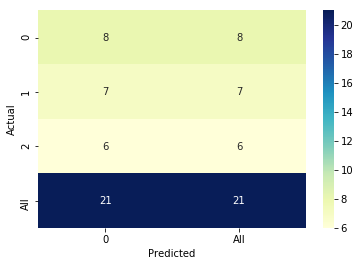

********************************
gbm
Stride-based model performance:  0.7741935483870968 0.771762357088266 0.7769791572640997 0.7724456048485034 0.9186603527852686
GradientBoostingClassifier(max_depth=7, max_features=5, min_samples_split=4,
                           n_estimators=50, random_state=0)
Person-based model performance:  0.9523809523809523 0.9583333333333334 0.9583333333333334 0.9555555555555556 1.0


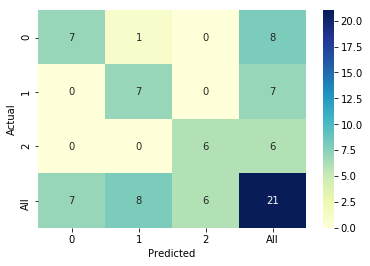

********************************
xgboost
Stride-based model performance:  0.7586618876941458 0.7559482571814332 0.7613325860260537 0.7562732969529362 0.9142148191008128
XGBClassifier(colsample_bytree=1.0, gamma=1, max_depth=5,
              objective='multi:softprob', subsample=1.0)
Person-based model performance:  0.9523809523809523 0.9583333333333334 0.9583333333333334 0.9555555555555556 1.0


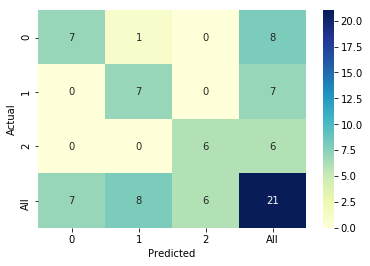

********************************
knn
Stride-based model performance:  0.7228195937873357 0.7234083667462422 0.7103844923943292 0.7138754987317882 0.8757700046391829
KNeighborsClassifier(n_neighbors=10, p=1)
Person-based model performance:  0.9523809523809523 0.9629629629629629 0.9444444444444445 0.9500891265597148 0.9781746031746031


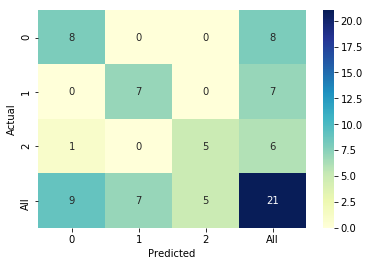

********************************
decision_tree
Stride-based model performance:  0.5854241338112306 0.5818235787702867 0.5820939438022127 0.5808965829995936 0.7202708761478128
DecisionTreeClassifier(min_samples_split=10, random_state=0)
Person-based model performance:  0.7619047619047619 0.7916666666666666 0.7658730158730159 0.7752525252525252 0.9285714285714285


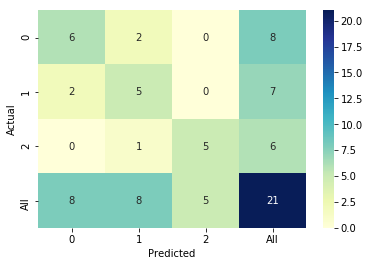

********************************
linear_svm
Stride-based model performance:  0.7025089605734767 0.6981062838336118 0.6939808177137016 0.6919573464409409 0.8578978795823856
LinearSVC(random_state=0)
Person-based model performance:  0.8571428571428571 0.8611111111111112 0.8551587301587302 0.8555555555555556 0.9464285714285715


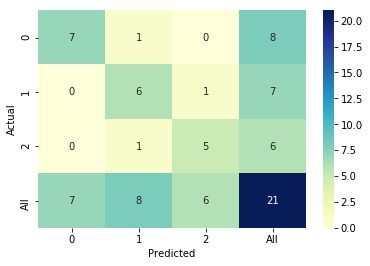

********************************
logistic_regression
Stride-based model performance:  0.7025089605734767 0.6985171181426758 0.6941854875445288 0.6916191425501821 0.862530780784076
LogisticRegression(random_state=0)
Person-based model performance:  0.9523809523809523 0.9583333333333334 0.9444444444444445 0.9474747474747475 0.9613095238095238


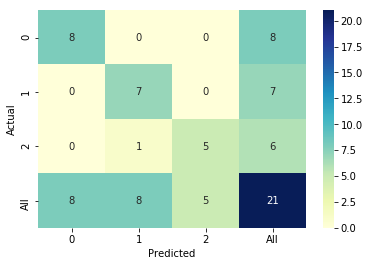

********************************
mlp
Stride-based model performance:  0.5770609318996416 0.5605673670543169 0.5663875459982325 0.5566770452131545 0.6879492677718138
MLPClassifier(hidden_layer_sizes=(5, 5, 5, 5, 30, 5, 20, 30, 100, 50),
              learning_rate='adaptive', max_iter=500, random_state=0,
              shuffle=False)
Person-based model performance:  0.7142857142857143 0.7888888888888889 0.7202380952380952 0.674074074074074 0.9117063492063492


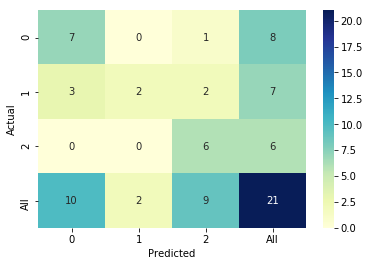

********************************


In [68]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person_VB, stride_person_metrics_VB = models(trainX_norm_VBW, trainY_VBW, testX_norm_VBWT, testY_VBWT, ml_model, \
                                                              framework, results_path, save_results)
    metrics_VB[ml_model] = stride_person_metrics_VB
    predicted_probs_person_VB[ml_model+'_HOA'] = predict_probs_person_VB[0]
    predicted_probs_person_VB[ml_model+'_MS'] = predict_probs_person_VB[1]
    predicted_probs_person_VB[ml_model+'_PD'] = predict_probs_person_VB[2]
    print ('********************************')

metrics_VB.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
if save_results:
    metrics_VB.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
    predicted_probs_person_VB.to_csv(results_path+framework+'\\task_generalize_'+framework+'_prediction_probs.csv')

In [69]:
metrics_VB

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_accuracy,0.561529,0.568698,0.407407,0.774194,0.758662,0.722820,0.585424,0.702509,0.702509,0.577061
stride_precision,0.567641,0.548324,0.135802,0.771762,0.755948,0.723408,0.581824,0.698106,0.698517,0.560567
stride_recall,0.558610,0.548051,0.333333,0.776979,0.761333,0.710384,0.582094,0.693981,0.694185,0.566388
stride_F1,0.556895,0.547511,0.192982,0.772446,0.756273,0.713875,0.580897,0.691957,0.691619,0.556677
stride_AUC,0.746940,0.778636,0.194081,0.918660,0.914215,0.875770,0.720271,0.857898,0.862531,0.687949
person_accuracy,0.666667,0.666667,0.380952,0.952381,0.952381,0.952381,0.761905,0.857143,0.952381,0.714286
person_precision,0.700529,0.673810,0.126984,0.958333,0.958333,0.962963,0.791667,0.861111,0.958333,0.788889
person_recall,0.662698,0.656746,0.333333,0.958333,0.958333,0.944444,0.765873,0.855159,0.944444,0.720238
person_F1,0.666667,0.646206,0.183908,0.955556,0.955556,0.950089,0.775253,0.855556,0.947475,0.674074
person_AUC,0.802083,0.852679,0.500000,1.000000,1.000000,0.978175,0.928571,0.946429,0.961310,0.911706


In [70]:
#ROC 
plot_ROC(ml_models, testY_VBWT, predicted_probs_person_VB, framework, results_path, save_results)

TypeError: plot_ROC() missing 1 required positional argument: 'results_path'

In [ ]:
#Confusion matrices - Done
#micro/macro/weighted metric scores 
#Why is AUC 1 for low accuracy